In [225]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches

In [226]:
data = pd.read_csv('data/Churn_Modelling.csv')

In [227]:
X = data.drop(['RowNumber', 'CustomerId', 'Surname', 'Exited'], axis=1)
Y = data['Exited']

# Separate the features and the labels
labels = data['Exited']

# Define which columns should be encoded vs scaled
columns_to_encode = ['Geography', 'Gender']
columns_to_scale  = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

# Create a ColumnTransformer to transform the columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), columns_to_scale),
        ('cat', OneHotEncoder(), columns_to_encode)
    ])

# Fit and transform the data
X_processed = preprocessor.fit_transform(X)

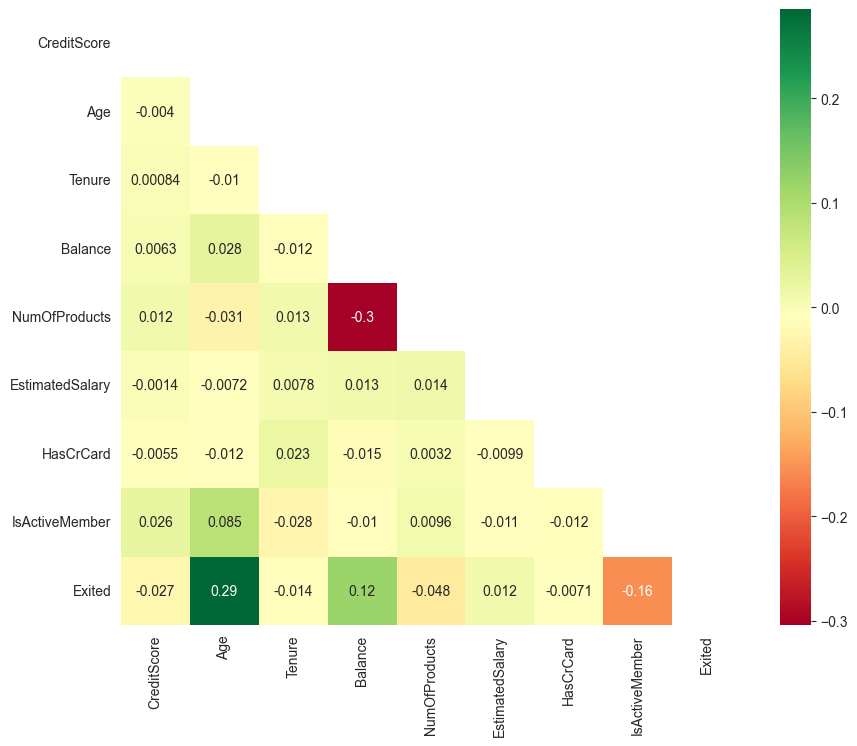

In [228]:
data4 = data[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'HasCrCard', 'IsActiveMember', 'Exited']].copy()
correlation = data4.corr()

mask = np.zeros_like(correlation)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, mask=mask, annot=True, cmap='RdYlGn')
plt.show()

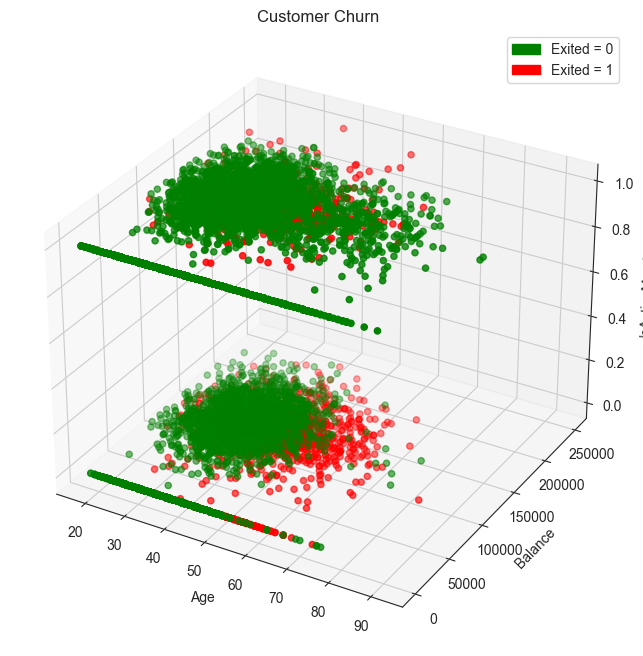

In [234]:
# Visualizing the Space of Highly Correlated Variables ie. Age, Balance, isActiveMember. 3-d plot for both Exited 0 and 1

fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(111, projection='3d')
ax.set_title('Customer Churn')

# Scatter plot for Exited = 0
x = data4[data4['Exited'] == 0]['Age']
y = data4[data4['Exited'] == 0]['Balance']
z = data4[data4['Exited'] == 0]['IsActiveMember']

ax.scatter(x, y, z, c='g', marker='o')

# Scatter plot for Exited = 1
x = data4[data4['Exited'] == 1]['Age']
y = data4[data4['Exited'] == 1]['Balance']
z = data4[data4['Exited'] == 1]['IsActiveMember']

ax.scatter(x, y, z, c='r', marker='o')

ax.set_xlabel('Age')
ax.set_ylabel('Balance')
ax.set_zlabel('IsActiveMember')

blue_patch = mpatches.Patch(color='green', label='Exited = 0')
red_patch = mpatches.Patch(color='red', label='Exited = 1')

plt.legend(handles=[blue_patch, red_patch])
plt.show()




In [192]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [193]:
def plot_cluster_metrics(X_processed, N):
    wcss = []
    silhouette_coefficients = []   
    for i in range(2, N):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(X_processed)
        wcss.append(kmeans.inertia_)
        score = silhouette_score(X_processed, kmeans.labels_)
        silhouette_coefficients.append(score)

    # Plot the elbow plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, N), wcss, marker='o')
    plt.title('Elbow Method For Optimal k')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Plot the silhouette coefficients
    plt.figure(figsize=(10, 6))
    plt.plot(range(2, N), silhouette_coefficients, marker='o')
    plt.title('Silhouette Coefficients For Various Clusters')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Coefficient')
    plt.show()
    

In [ ]:
plot_cluster_metrics(X_processed, 11)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to '

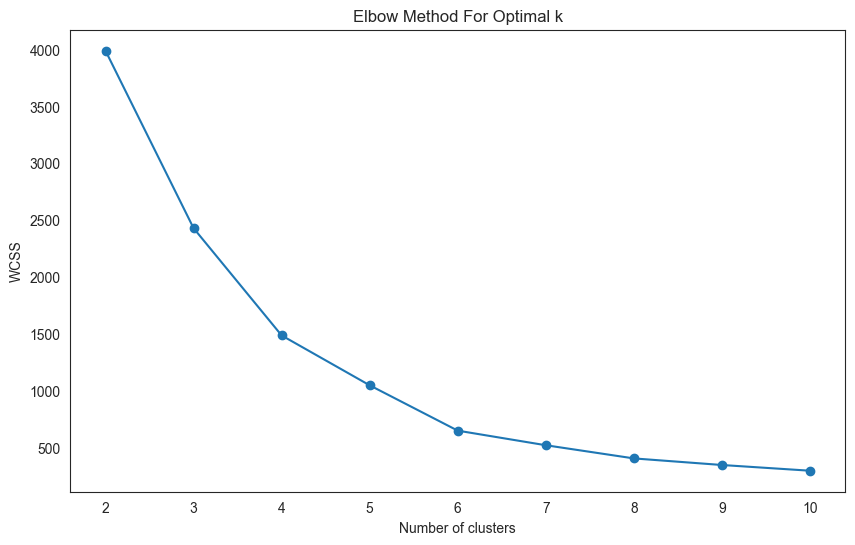

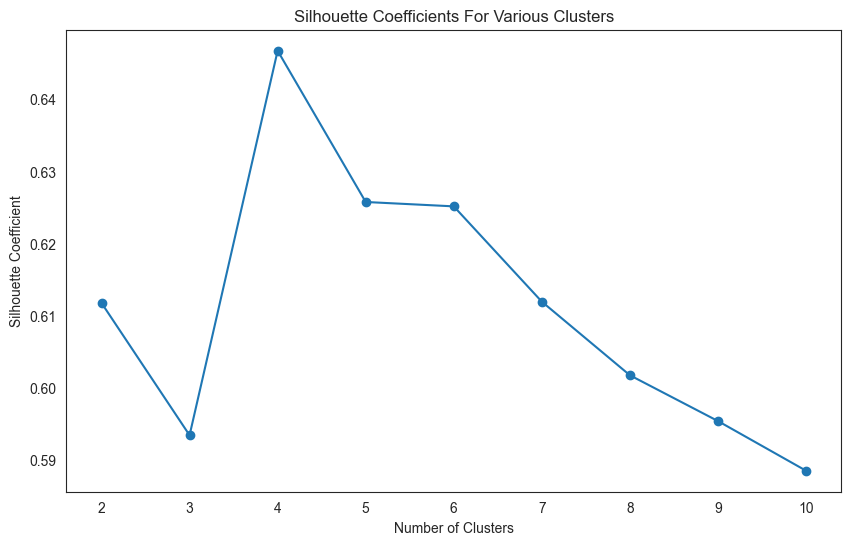

In [222]:
dfCorrX = data.reindex(['Age', 'Balance','IsActiveMember'], axis=1)


cols_to_scale = ['Balance']
scaler = StandardScaler()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', scaler, cols_to_scale)
    ])

# Normalize 'Age'  Divide each column (variable) by its maximum
dfCorrX['Age'] = dfCorrX['Age'] / dfCorrX['Age'].max()

dfCorrX['Balance'] = preprocessor.fit_transform(dfCorrX[['Balance']])
CorrX = dfCorrX.values

# X_scaled = preprocessor.fit_transform(dfCorrX)
plot_cluster_metrics(CorrX, 11)


In [196]:
# Downsample the majority class ie. Exited = 0
from sklearn.utils import resample

def downsample_data(data, target):
    # Separate majority and minority classes
    data_majority = data[data[target] == 0]
    data_minority = data[data[target] == 1]

    # Downsample the majority class
    data_majority_downsampled = resample(data_majority, 
                                     replace=False,    # sample without replacement
                                     n_samples=data_minority.shape[0],     # to match minority class
                                     random_state=42) # reproducible results

    # Combine minority class with downsampled majority class
    data_downsampled = pd.concat([data_majority_downsampled, data_minority])

    # Display new class counts
    print(data_downsampled[target].value_counts())

    X_downsampled = data_downsampled.drop(['RowNumber', 'CustomerId', 'Surname', target], axis=1)
    Y_downsampled = data_downsampled[target]

    # Define which columns should be encoded vs scaled
    columns_to_encode = ['Geography', 'Gender']
    columns_to_scale  = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

    # Create a ColumnTransformer to transform the columns
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), columns_to_scale),
            ('cat', OneHotEncoder(), columns_to_encode)
        ])

    # Fit and transform the data
    X_downsampled_processed = preprocessor.fit_transform(X_downsampled)
    
    return X_downsampled_processed, Y_downsampled

X_downsampled_processed, Y_downsampled = downsample_data(data, 'Exited')

# plot_cluster_metrics(X_downsampled_processed, 11)


Exited
0    2037
1    2037
Name: count, dtype: int64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


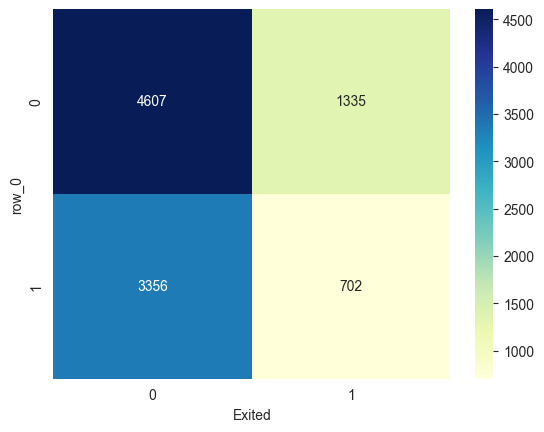

/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_6423/3647995563.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_means = df.groupby('Cluster')[numeric_cols].mean()


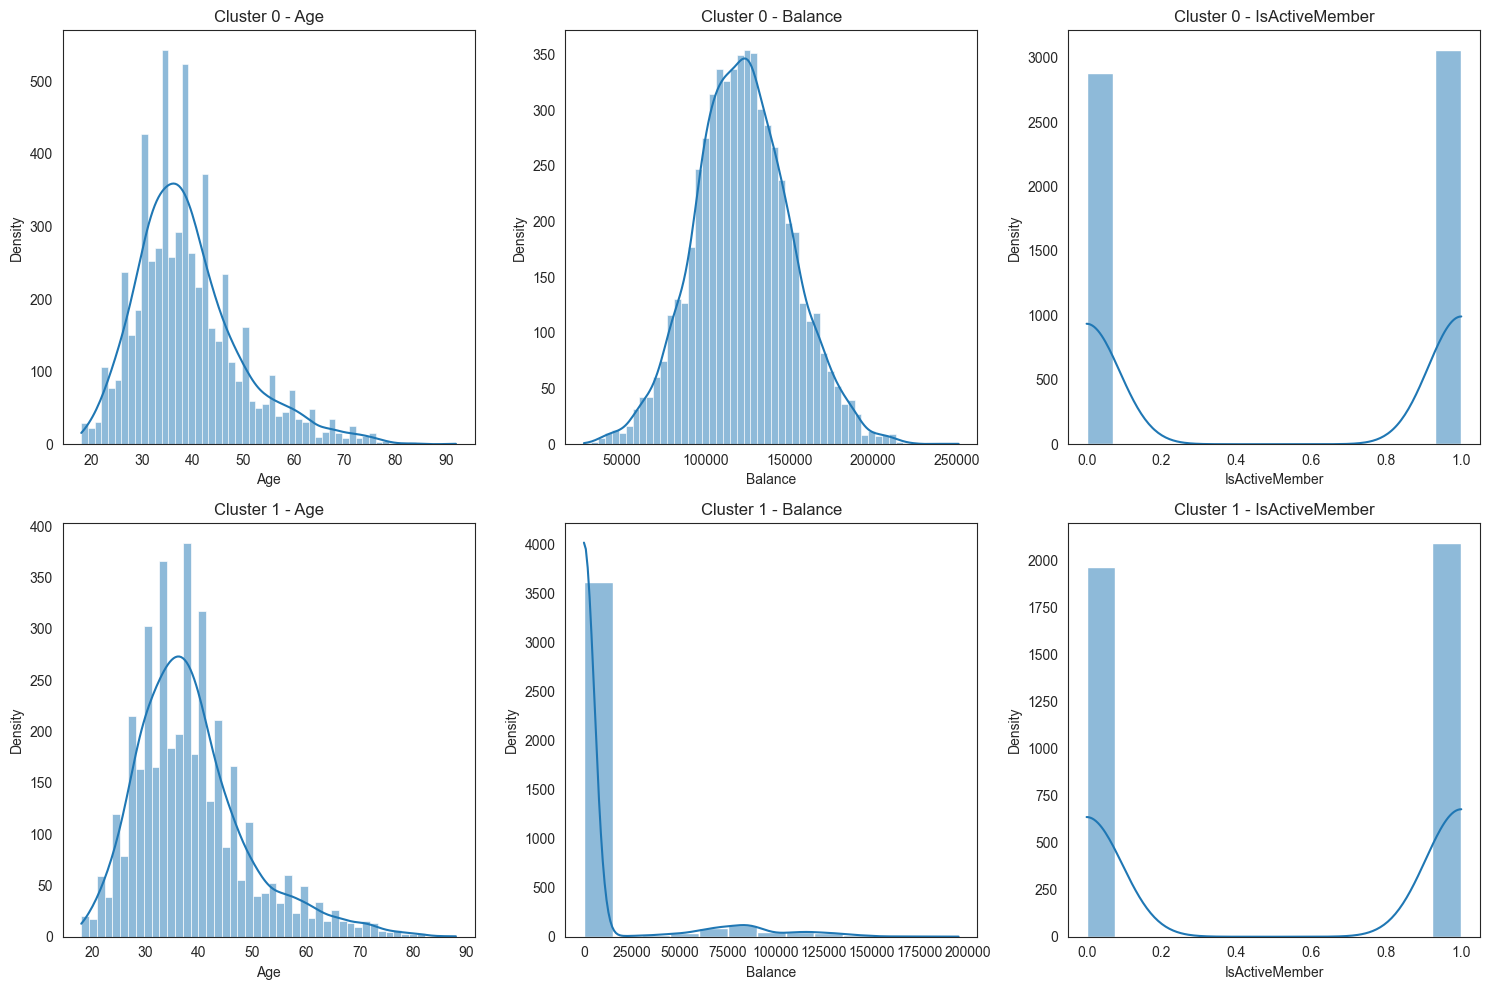

In [197]:
def perform_clustering(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(data)
    return cluster_labels, kmeans

def calculate_crosstab(df, cluster_labels):
    crosstab = pd.crosstab(cluster_labels, df['Exited'])
    return crosstab

def cluster_profiles(df, cluster_labels):
    df['Cluster'] = pd.Categorical(cluster_labels)
    
    # Select only numeric columns for mean calculation
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    cluster_means = df.groupby('Cluster')[numeric_cols].mean()
    
    return cluster_means

def visualize_crosstab(crosstab):
    sns.heatmap(crosstab, annot=True, fmt="d", cmap="YlGnBu")
    plt.show()

def plot_cluster_distributions(df, cluster_labels, features):
    num_clusters = df[cluster_labels].nunique()
    num_features = len(features)
    
    fig, axs = plt.subplots(num_clusters, num_features, figsize=(5 * num_features, 5 * num_clusters))
    
    for i in range(num_clusters):
        for j, feature in enumerate(features):
            if num_clusters == 1:
                ax = axs[j]
            else:
                ax = axs[i, j]
            
            sns.histplot(df[df[cluster_labels] == i][feature], kde=True, ax=ax)
            ax.set_title(f'Cluster {i} - {feature}')
            ax.set_xlabel(feature)
            ax.set_ylabel('Density')
            
    plt.tight_layout()
    plt.show()


labels_2, model_2 = perform_clustering(X_processed, 2)

# Calculate crosstabs
crosstab_2 = calculate_crosstab(data, labels_2)

# Visualize crosstabs
visualize_crosstab(crosstab_2)

# Get cluster profiles
profiles_2 = cluster_profiles(data, labels_2)



features_to_plot = ['Age', 'Balance', 'IsActiveMember']  # Add all feature names you want to plot
plot_cluster_distributions(data, 'Cluster', features_to_plot)

#### Crosstab Results for 2 Clusters:

Cluster 0 has a lower proportion of customers who exited (1335 out of 5942, approximately 22.5%) compared to Cluster 1 (702 out of 4058, approximately 17.3%). This suggests that customers in Cluster 0 may be at a higher risk of churn than those in Cluster 1.

Distribution Plots:

Age: Both clusters have similar age distributions, but Cluster 1 seems to have a slightly younger skew.
Balance: Cluster 1 has a spike at the lower balance range, indicating a significant number of customers with lower bank balances, which could suggest a different financial behavior or service usage pattern compared to Cluster 0.
CreditScore: The distribution is quite similar for both clusters, indicating that credit score may not be the defining factor in differentiating between the clusters.

Analysis:

The crosstab results, along with the distribution plots, suggest that while there's a mix of churned and not churned customers in both clusters, Cluster 0 has a higher churn rate. This might be related to the balance distribution, where Cluster 1 has many customers with low balances, potentially indicating a segment of customers less engaged with the bank's services.
The distribution plots can also inform about potential strategies for customer engagement and retention. For instance, if a cluster with higher churn also has a notable segment of younger customers or customers with specific balance ranges, targeted financial products or services could be offered to these groups to improve retention.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


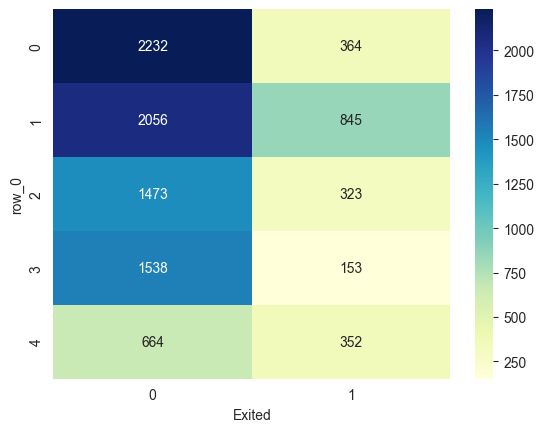

/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_6423/3647995563.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_means = df.groupby('Cluster')[numeric_cols].mean()


In [204]:
labels_5, model_5 = perform_clustering(X_scaled, 5)
crosstab_5 = calculate_crosstab(data, labels_5)
visualize_crosstab(crosstab_5)
profiles_5 = cluster_profiles(data, labels_5)






In [206]:
crosstab_5

Exited,0,1
row_0,,
0,2232,364
1,2056,845
2,1473,323
3,1538,153
4,664,352


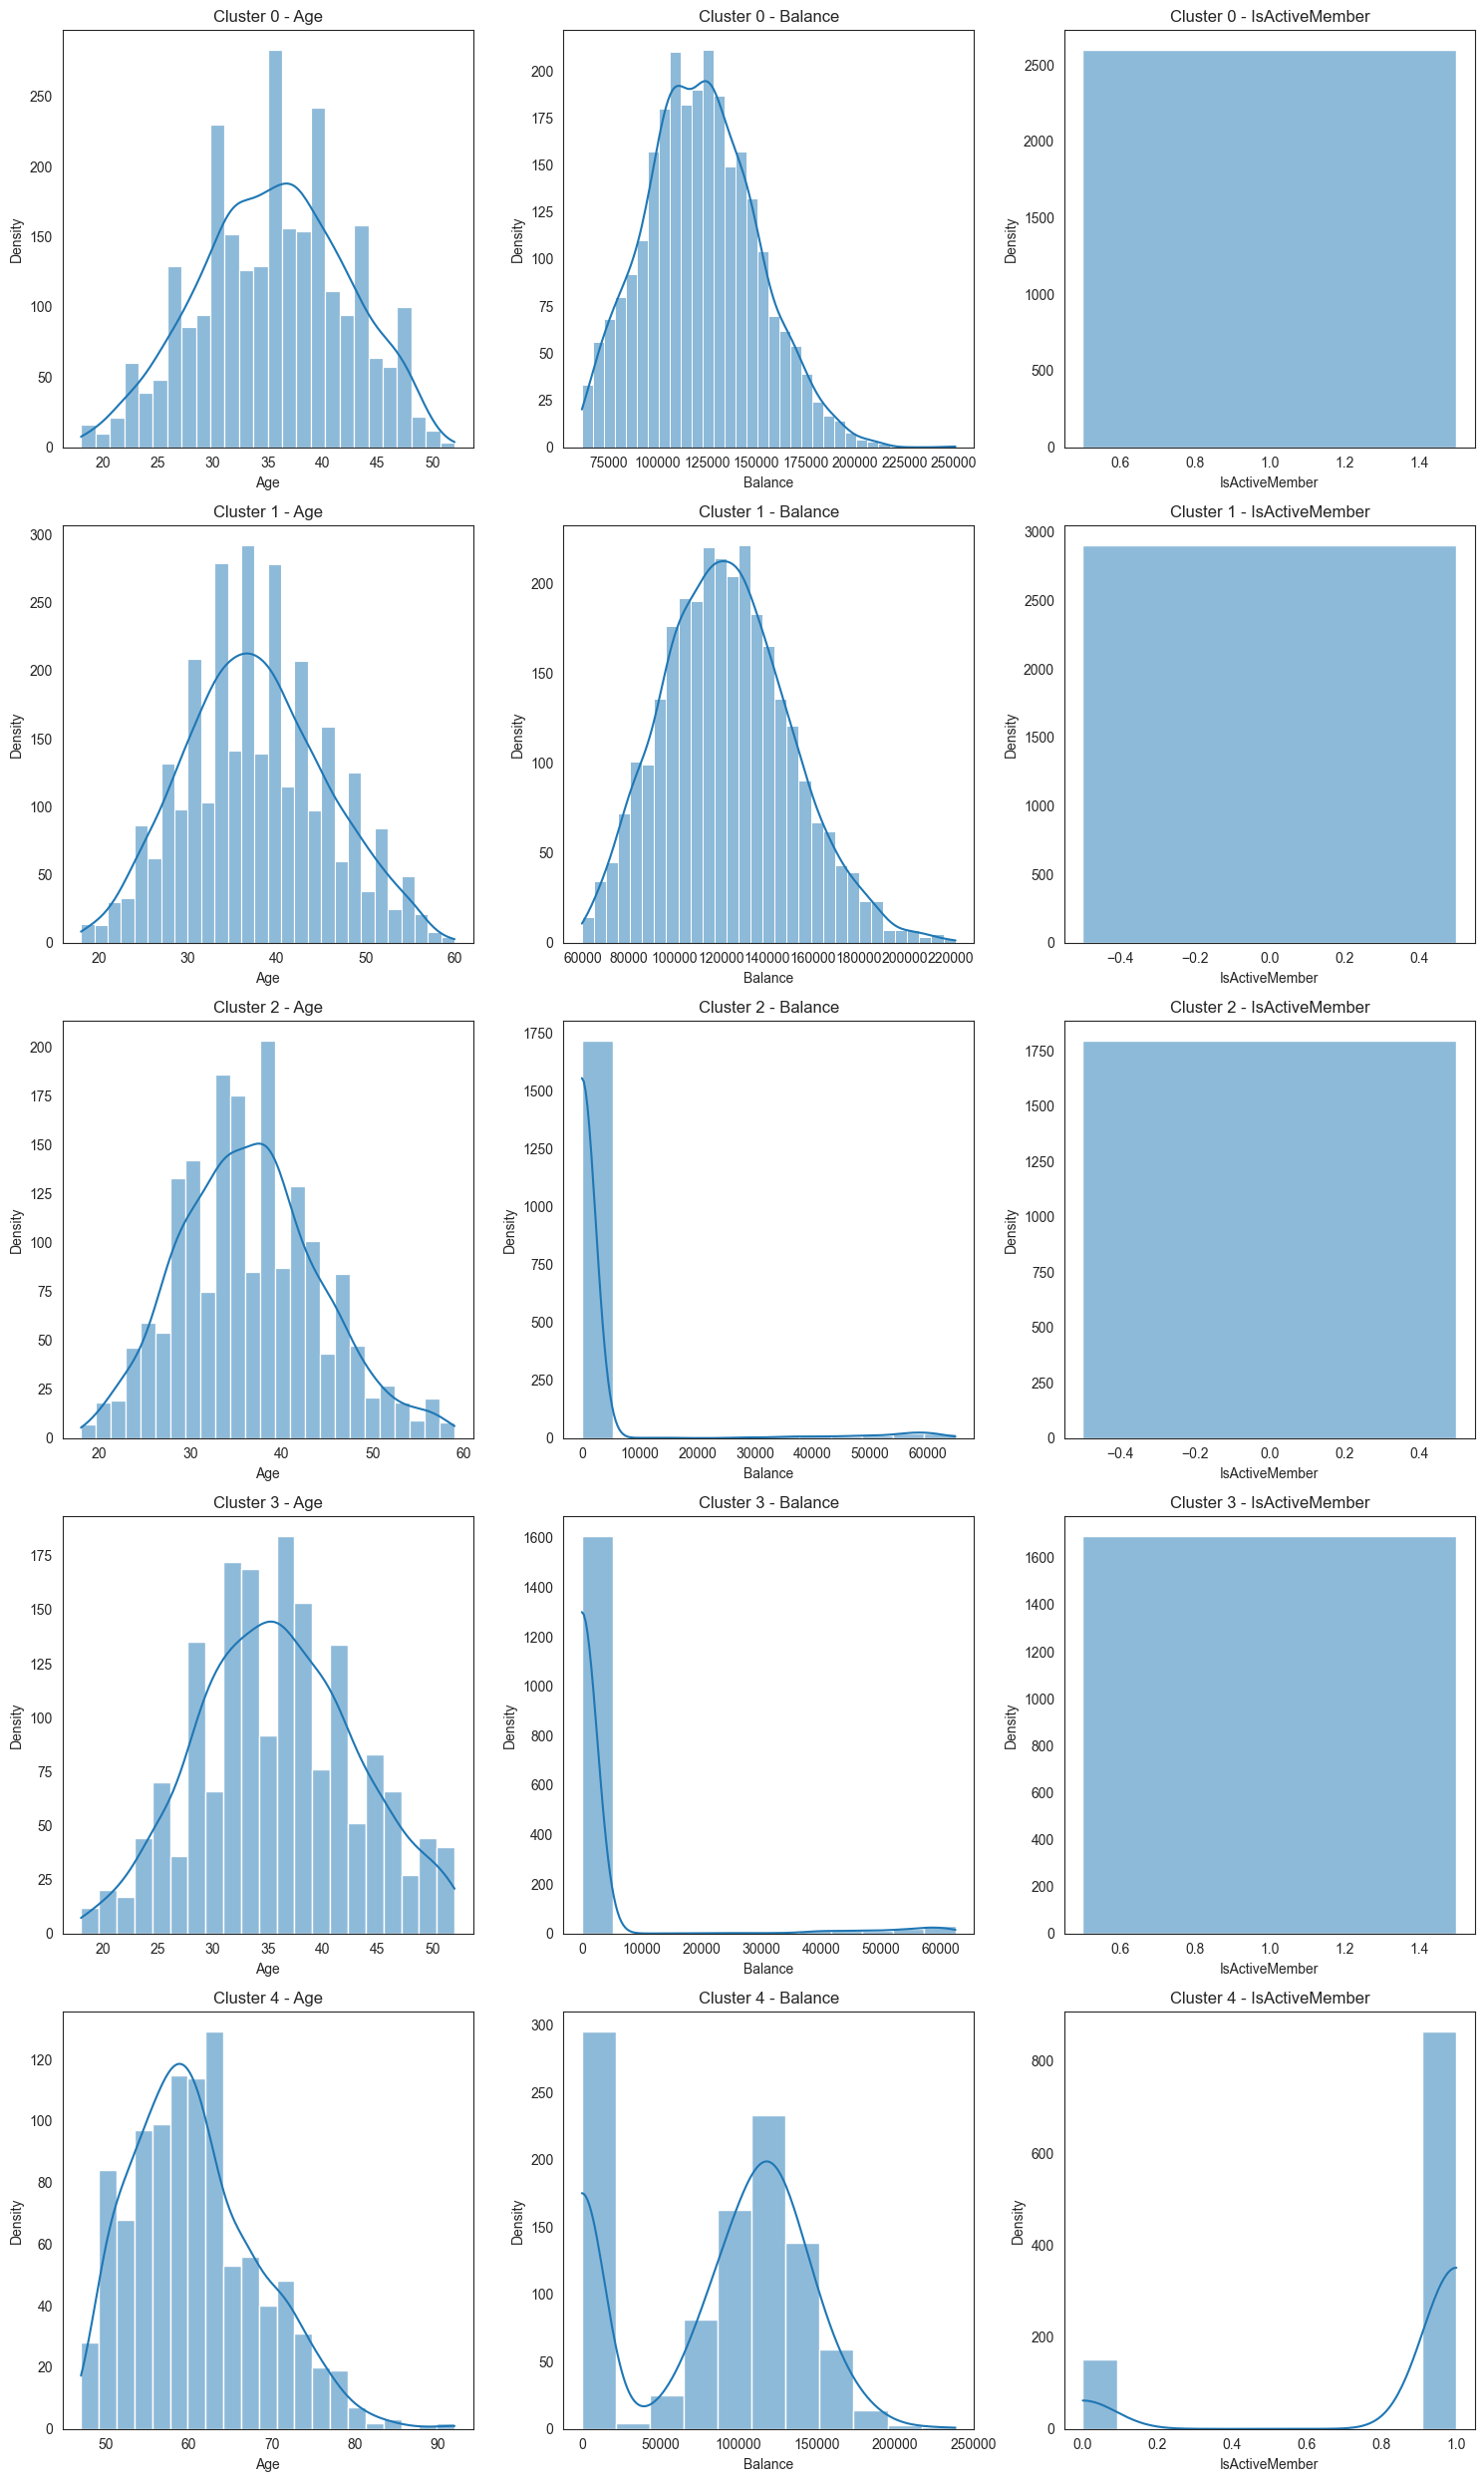

In [205]:
features_to_plot = ['Age', 'Balance', 'IsActiveMember']  # Add all feature names you want to plot
plot_cluster_distributions(data, 'Cluster', features_to_plot)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


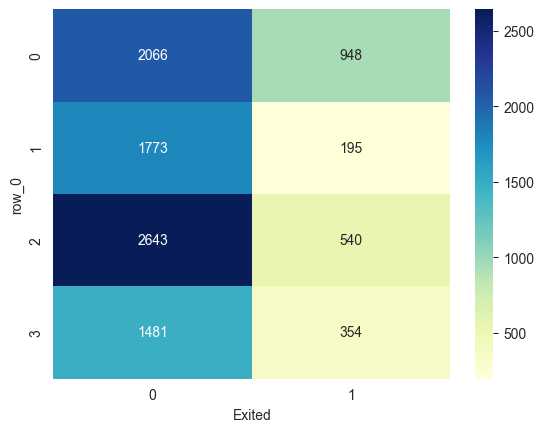

/var/folders/bs/tpyvns0s19x1_30wqyh01y2r0000gn/T/ipykernel_6423/3647995563.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_means = df.groupby('Cluster')[numeric_cols].mean()


In [223]:
labels_4, model_4 = perform_clustering(CorrX, 4)
crosstab_4 = calculate_crosstab(data, labels_4)
visualize_crosstab(crosstab_4)
profiles_5 = cluster_profiles(data, labels_4)

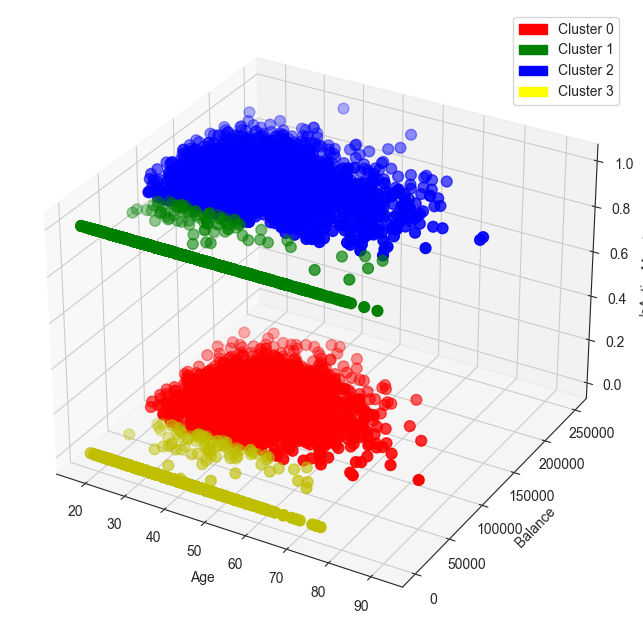

In [224]:
# Plot 3-d plots of the clusters for the first 3 features
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

colors = ['r', 'g', 'b', 'y', 'c', 'm']

for i in range(5):
    ax.scatter(data['Age'][labels_4 == i], data['Balance'][labels_4 == i], data['IsActiveMember'][labels_4 == i], c=colors[i], s=60)

ax.set_xlabel('Age')
ax.set_ylabel('Balance')

ax.set_zlabel('IsActiveMember')

red_patch = mpatches.Patch(color='red', label='Cluster 0')
green_patch = mpatches.Patch(color='green', label='Cluster 1')
blue_patch = mpatches.Patch(color='blue', label='Cluster 2')
yellow_patch = mpatches.Patch(color='yellow', label='Cluster 3')

plt.legend(handles=[red_patch, green_patch, blue_patch, yellow_patch])
plt.show()





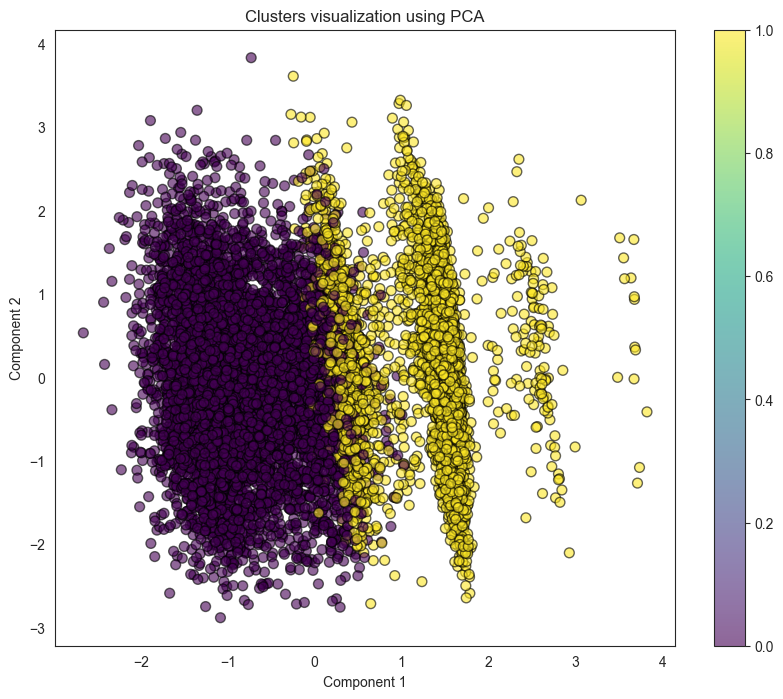

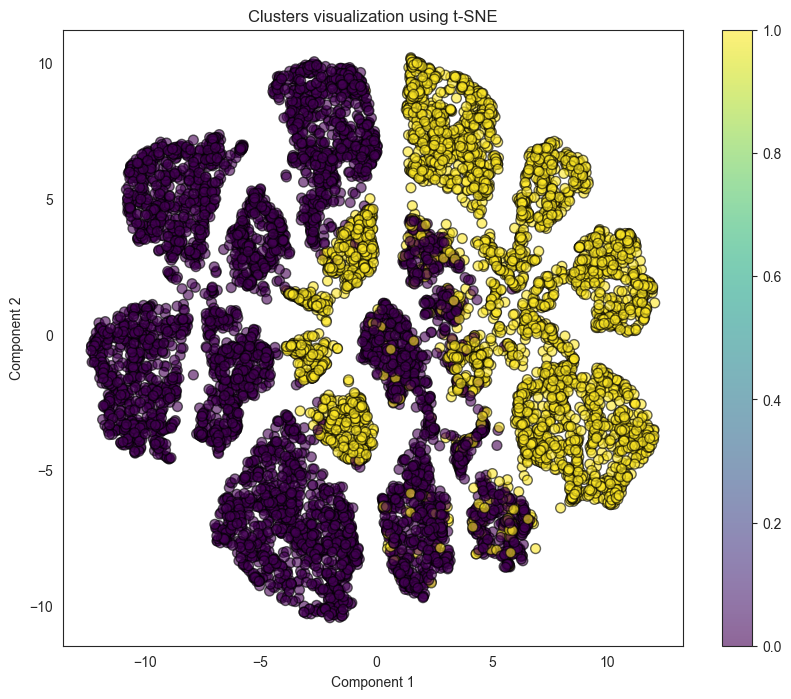

In [183]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Let's say `X_processed` is your scaled and encoded data and `cluster_labels` are your clustering results.

# Using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

# Using t-SNE
tsne = TSNE(n_components=2, perplexity=30, n_iter=300)
X_tsne = tsne.fit_transform(X_processed)

# Function to plot
def plot_clusters(X_2d, cluster_labels, algorithm_name='Algorithm'):
    plt.figure(figsize=(10, 8))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=cluster_labels, cmap='viridis', marker='o', edgecolor='k', s=50, alpha=0.6)
    plt.colorbar()
    plt.title(f'Clusters visualization using {algorithm_name}')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.show()

# Now plot the results
plot_clusters(X_pca, labels_2, 'PCA')
plot_clusters(X_tsne, labels_2, 't-SNE')
